In [1]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
import bisect
import functools
import itertools
import pickle as pkl
import time
from IPython.display import clear_output
%matplotlib inline
from PIL import Image
import sklearn

In [2]:
# read all band images in a directory
images = {}
image_dir = '2014/images/'
for fn in os.listdir(image_dir):
    raw = gdal.Open(image_dir + fn)
    arr = raw.ReadAsArray()
    images[fn.split('.')[0]] = arr

In [3]:
# read all mask images in a directory
masks = {}
mask_dir = '2014/masks/'
for fn in os.listdir(mask_dir):
    raw = gdal.Open(mask_dir + fn)
    arr = raw.ReadAsArray()
    masks[fn.split('.')[0]] = arr

In [4]:
# compose band and mask images into one image
combined = {}
# image_dir = 'earthengine_images/'
# mask_dir = 'earthengine_masks/'
for fn in os.listdir(image_dir):
    raw_img = gdal.Open(image_dir + fn)
    arr_img = raw_img.ReadAsArray()
    raw_msk = gdal.Open(mask_dir + fn)
    arr_msk = raw_msk.ReadAsArray()
    combined[fn.split('.')[0]] = np.concatenate((arr_img, arr_msk), axis=0)

In [5]:
# use image names to look up metadata from csv export
table = pd.read_csv('2014/tables/LC8_SR.csv')
time_start = table[['system:index', 'system:time_start']]

In [6]:
# compose all data into a single data frame
ds = {}
for k, v in combined.items():
    ts = time_start[time_start['system:index'] == k]['system:time_start'].iloc[0]
    ds[ts] = v

In [7]:
t = list(ds.keys())
t.sort()
print(t)

[1393632987225, 1394410211566, 1395015377948, 1395792595786, 1397780144150, 1398557367125, 1399162529511, 1399939752769, 1400544919916, 1401322152255, 1401927327676, 1402704560525, 1404086963402, 1404692138926, 1405469370600, 1406074541664, 1406851776359, 1408234182394, 1408839353835, 1409616584607, 1410221757598, 1410998985984, 1412381389175, 1412986561487, 1413763792495, 1414368960709, 1415146191267, 1415751363029, 1416528587183, 1417133760843, 1417910986952, 1418516154655, 1419293385395, 1419898551514, 1420675781417, 1421280950873, 1422058174921, 1422663346261]


Alternative flow:

In [8]:
def get_boolean_mask(image, level=1):
    cfmask = image[3, :, :]
    cfmask_conf = image[4, :, :]
    return (cfmask == 0) & (cfmask_conf <= level)

In [9]:
def zigzag_integer_pairs(max_x, max_y):
    total = 0
    x = 0
    while total <= max_x + max_y:
        if total - x <= max_y:
            yield (x, total - x)
        if x <= min(max_x - 1, total - 1):
            x += 1
        else:
            total += 1
            x = 0

In [10]:
print([x for x in zigzag_integer_pairs(3, 5)])

[(0, 0), (0, 1), (1, 0), (0, 2), (1, 1), (2, 0), (0, 3), (1, 2), (2, 1), (3, 0), (0, 4), (1, 3), (2, 2), (3, 1), (0, 5), (1, 4), (2, 3), (3, 2), (1, 5), (2, 4), (3, 3), (2, 5), (3, 4), (3, 5)]


In [11]:
def interpolate(timestamp, dataset):
    times = list(dataset.keys())
    times.sort()
    pos = bisect.bisect(times, timestamp)
    n_times = len(times)
    dims = dataset[times[0]].shape
    interpolated = np.zeros((3, dims[1], dims[2]))
    times_before = times[:pos]
    times_before.reverse()
    times_after = times[pos:]
    unfilled = np.ones(dims[1:], dtype=bool)
    for pair in zigzag_integer_pairs(len(times_before) - 1, len(times_after) - 1):
        before = times_before[pair[0]]
        after = times_after[pair[1]]
        alpha = 1.0 * (timestamp - before) / (after - before)
        mask_before = get_boolean_mask(dataset[before])
        mask_after = get_boolean_mask(dataset[after])
        common_unmasked = mask_before & mask_after
        valid = common_unmasked & unfilled
#         fitted = dataset[before][:3, :, :] * alpha + dataset[after][:3, :, :] * (1 - alpha)
        fitted = np.zeros((3, dims[1], dims[2]))
        fitted[:, valid] = dataset[before][:3, valid] * alpha + dataset[after][:3, valid] * (1 - alpha)
        unfilled = unfilled ^ valid
        interpolated[:, valid] = fitted[:, valid]
    # todo: deal with timestamps before the first image or after the last
    # todo: deal with only having masked pixels on one side
    # the above two can be achieved with one-sided value filling
    # interpolate at existing time - remove cloud (should be working already)
    times.sort(key=lambda t: abs(t - timestamp))
    for ts in times:
        mask = get_boolean_mask(dataset[ts])
        valid = mask & unfilled
        unfilled = unfilled ^ valid
        interpolated[:, valid] = dataset[ts][:3, valid]
    return interpolated

In [12]:
def interpolate_images(timestamps, dataset):
    return {ts: interpolate(ts, dataset) for ts in timestamps}

In [55]:
times = list(ds.keys())
times.sort()
midpoints = []
for i in range(len(times) - 1):
#     if i % 3 == 0:
        midpoints += [int((times[i] + times[i+1]) / 2)]
print(midpoints)

[1394021599395, 1394712794757, 1395403986867, 1396786369968, 1398168755637, 1398859948318, 1399551141140, 1400242336342, 1400933536085, 1401624739965, 1402315944100, 1403395761963, 1404389551164, 1405080754763, 1405771956132, 1406463159011, 1407542979376, 1408536768114, 1409227969221, 1409919171102, 1410610371791, 1411690187579, 1412683975331, 1413375176991, 1414066376602, 1414757575988, 1415448777148, 1416139975106, 1416831174013, 1417522373897, 1418213570803, 1418904770025, 1419595968454, 1420287166465, 1420978366145, 1421669562897, 1422360760591]


In [56]:
fitted_images = interpolate_images(midpoints, ds)

In [57]:
def convert_to_dataframe(image):
    frame = pd.Panel(image).to_frame()
    return frame

In [58]:
def make_set(images):
    times = list(images.keys())
    times.sort()
    res = pd.concat([convert_to_dataframe(i) for i in images.values()], axis=1, keys=images.keys())
#     res = pd.concat(list(map(convert_to_dataframe, images.values())), axis=0)
    return res.reset_index()

In [59]:
train = make_set(fitted_images)
train.head(10)

major minor 1420287166465                           1416139975106          \
                          0            1            2             0       1   
0     0     0   2536.327143  1207.073539   797.913266        2592.5  1344.5   
1     0     1   2620.854873  1392.778400  1004.750059        2915.5  1564.5   
2     0     2   2628.311506  1359.532614  1003.801855        3184.0  1615.0   
3     0     3   2603.136817  1359.172976  1000.924748        3476.0  1723.5   
4     0     4   2523.646467  1277.032004   925.152454        3614.5  1732.5   
5     0     5   2406.460296  1198.907890   896.336183        3517.0  1680.0   
6     0     6   1798.904226   519.680676   443.041535        2422.5   900.5   
7     0     7   2007.104813   484.565110   405.870510        2376.0   661.0   
8     0     8   2065.725874   649.639140   510.525287        2561.5   906.5   
9     0     9   2455.256046  1324.491571   993.833130        2943.0  1345.0   

          1394712794757            ...     1412683975331 1411690187579  \
        2             0      1     ...                 2             0   
0   901.5        3683.0  300.0     ...             718.5   5501.500036   
1  1078.0        3683.0  300.0     ...             802.5   5501.500036   
2  1129.5        3438.0  349.0     ...             735.0   5246.000027   
3  1205.0        3089.0  429.0     ...             711.0   4810.900020   
4  1198.5        2897.0  473.0     ...             660.0   4549.600018   
5  1168.0        2897.0  473.0     ...             622.5   4549.600018   
6   710.5        1947.0  327.0     ...             401.0   2385.499969   
7   531.5        1749.0  206.0     ...             355.0   1910.799989   
8   673.0        2246.0  607.0     ...             458.5   2818.599999   
9   937.0        2311.0  777.0     ...             569.5   3105.300009   

                          1404389551164                         1401624739965  \
            1           2             0           1           2             0   
0  415.699988  732.599999   3736.022648  299.408119  523.058050   4220.502289   
1  415.699988  732.599999   3784.359573  302.268876  529.716708   4710.504375   
2  453.199993  796.000003   3532.059711  349.049323  559.842420   4391.504060   
3  444.699996  719.200001   3200.273575  425.103452  571.250539   4217.004803   
4  425.899997  661.100001   2992.983323  467.130516  567.847225   3870.004143   
5  425.899997  661.100001   2947.753772  464.072466  560.448716   3411.502191   
6  265.099996  360.499996   1941.278486  317.628555  380.242695   1888.999753   
7  174.399995  246.299997   1782.194644  208.712787  258.044518   2085.501433   
8  421.299994  478.499998   2254.680917  589.934106  499.516376   2334.000375   
9  561.100003  647.500005   2359.386249  765.754266  689.067661   2801.502088   

                           
            1           2  
0  293.999974  551.000132  
1  323.000098  618.500419  
2  349.500002  631.500338  
3  389.499832  637.500313  
4  413.499747  603.000166  
5  382.499615  527.999847  
6  231.999596  318.499708  
7  233.500117  295.000175  
8  433.999263  421.999634  
9  662.999515  643.999787  

[10 rows x 113 columns]

Load labels

In [60]:
label_image = Image.open('labels/labels.png')

In [61]:
print(label_image.size)

(1022, 973)


In [62]:
print(ds[list(ds.keys())[0]].shape)

(5, 973, 1022)


In [63]:
labels = np.array(label_image)

In [64]:
labels.shape

(973, 1022, 3)

In [65]:
pix_array = labels.reshape(labels.shape[0] * labels.shape[1], labels.shape[2])

In [66]:
# unique colours in the label pic
label_colours = np.vstack({tuple(row) for row in pix_array})
label_colours

array([[246, 255,   0],
       [252,   0, 255],
       [  0, 255, 102],
       [  0,   0,   0],
       [  0, 156, 255],
       [255, 156,   0],
       [171, 239, 170]], dtype=uint8)

In [67]:
label_map = {tuple(row):i for row, i in zip(label_colours, range(label_colours.shape[0]))}

In [68]:
label_map

{(0, 0, 0): 3,
 (0, 156, 255): 4,
 (0, 255, 102): 2,
 (171, 239, 170): 6,
 (246, 255, 0): 0,
 (252, 0, 255): 1,
 (255, 156, 0): 5}

In [69]:
label_converted = np.apply_along_axis(lambda x: label_map[tuple(x)], 2, labels)
label_converted

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 5, 5, ..., 3, 3, 3],
       ..., 
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [70]:
label_converted.shape

(973, 1022)

In [71]:
df = pd.DataFrame(label_converted)

In [72]:
df['x'] = df.index

In [73]:
label_set = pd.melt(df, id_vars='x')
label_set.head(10)

,x,variable,value
0,0,0,3
1,1,0,3
2,2,0,3
3,3,0,3
4,4,0,3
5,5,0,3
6,6,0,3
7,7,0,5
8,8,0,3
9,9,0,5


In [74]:
train_labelled = pd.merge(train, label_set, left_on=['major', 'minor'], right_on=['x', 'variable'], copy=False)
train_labelled = train_labelled.drop(['x', 'variable'], axis=1).rename(columns={('major', ''): 'x', ('minor', ''): 'y', 'value': 'label'})

/home/mithrillion/anaconda3/lib/python3.5/site-packages/pandas/tools/merge.py:205: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [75]:
train_labelled.head(10)

,x,y,"(1420287166465, 0)","(1420287166465, 1)","(1420287166465, 2)","(1416139975106, 0)","(1416139975106, 1)","(1416139975106, 2)","(1394712794757, 0)","(1394712794757, 1)",...,"(1411690187579, 0)","(1411690187579, 1)","(1411690187579, 2)","(1404389551164, 0)","(1404389551164, 1)","(1404389551164, 2)","(1401624739965, 0)","(1401624739965, 1)","(1401624739965, 2)",label
0,0,0,2536.327143,1207.073539,797.913266,2592.5,1344.5,901.5,3683.0,300.0,...,5501.500036,415.699988,732.599999,3736.022648,299.408119,523.058050,4220.502289,293.999974,551.000132,3
1,0,1,2620.854873,1392.778400,1004.750059,2915.5,1564.5,1078.0,3683.0,300.0,...,5501.500036,415.699988,732.599999,3784.359573,302.268876,529.716708,4710.504375,323.000098,618.500419,3
2,0,2,2628.311506,1359.532614,1003.801855,3184.0,1615.0,1129.5,3438.0,349.0,...,5246.000027,453.199993,796.000003,3532.059711,349.049323,559.842420,4391.504060,349.500002,631.500338,3
3,0,3,2603.136817,1359.172976,1000.924748,3476.0,1723.5,1205.0,3089.0,429.0,...,4810.900020,444.699996,719.200001,3200.273575,425.103452,571.250539,4217.004803,389.499832,637.500313,3
4,0,4,2523.646467,1277.032004,925.152454,3614.5,1732.5,1198.5,2897.0,473.0,...,4549.600018,425.899997,661.100001,2992.983323,467.130516,567.847225,3870.004143,413.499747,603.000166,3
5,0,5,2406.460296,1198.907890,896.336183,3517.0,1680.0,1168.0,2897.0,473.0,...,4549.600018,425.899997,661.100001,2947.753772,464.072466,560.448716,3411.502191,382.499615,527.999847,3
6,0,6,1798.904226,519.680676,443.041535,2422.5,900.5,710.5,1947.0,327.0,...,2385.499969,265.099996,360.499996,1941.278486,317.628555,380.242695,1888.999753,231.999596,318.499708,3
7,0,7,2007.104813,484.565110,405.870510,2376.0,661.0,531.5,1749.0,206.0,...,1910.799989,174.399995,246.299997,1782.194644,208.712787,258.044518,2085.501433,233.500117,295.000175,3
8,0,8,2065.725874,649.639140,510.525287,2561.5,906.5,673.0,2246.0,607.0,...,2818.599999,421.299994,478.499998,2254.680917,589.934106,499.516376,2334.000375,433.999263,421.999634,3
9,0,9,2455.256046,1324.491571,993.833130,2943.0,1345.0,937.0,2311.0,777.0,...,3105.300009,561.100003,647.500005,2359.386249,765.754266,689.067661,2801.502088,662.999515,643.999787,3


In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [77]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

In [78]:
X = train_labelled.ix[train_labelled.ix[:, 'label'] != 3, 2:-1]
y = train_labelled.ix[train_labelled.ix[:, 'label'] != 3, 'label']

In [79]:
cross_val_score(clf, X, y, cv=10, scoring='accuracy')

array([ 0.99212121,  0.983431  ,  0.99030107,  0.98464336,  0.99232168,
        0.99676702,  0.98989286,  0.98847787,  0.99110392,  0.99352751])

In [80]:
from collections import Counter

In [81]:
Counter(y)

Counter({0: 17706, 1: 331, 2: 17939, 4: 1939, 5: 8096, 6: 3468})

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [84]:
model = clf.fit(X_train, y_train)

In [85]:
pred = clf.predict(X_test)

In [86]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5778
          1       0.94      0.89      0.92       123
          2       1.00      1.00      1.00      5957
          4       1.00      0.99      0.99       653
          5       1.00      1.00      1.00      2688
          6       1.00      0.99      0.99      1130

avg / total       1.00      1.00      1.00     16329



In [87]:
# run clustering and observe outcome

In [88]:
from sklearn.cluster import KMeans

In [95]:
random_state = 170
X = train_labelled.ix[:, 2:-1]
y = train_labelled.ix[:, 'label']
cls = KMeans(n_clusters=12, random_state=random_state, n_jobs=8).fit_predict(X)

In [96]:
cls_table = train_labelled.iloc[:, :2]
cls_table['cluster'] = cls
cls_table.head()

,x,y,cluster
0,0,0,2
1,0,1,2
2,0,2,2
3,0,3,2
4,0,4,9


In [97]:
cls_map = cls_table.pivot(index='x', columns='y', values='cluster')

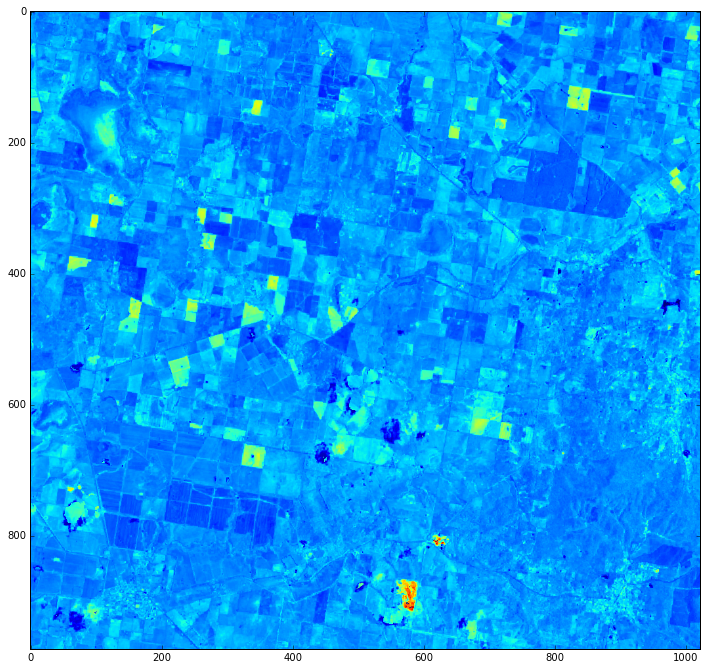

In [92]:
for p in midpoints:
    clear_output()
    plt.figure(figsize=(12, 12))
    plt.imshow(fitted_images[p][0, :, :])
    plt.show()
    time.sleep(0.5)

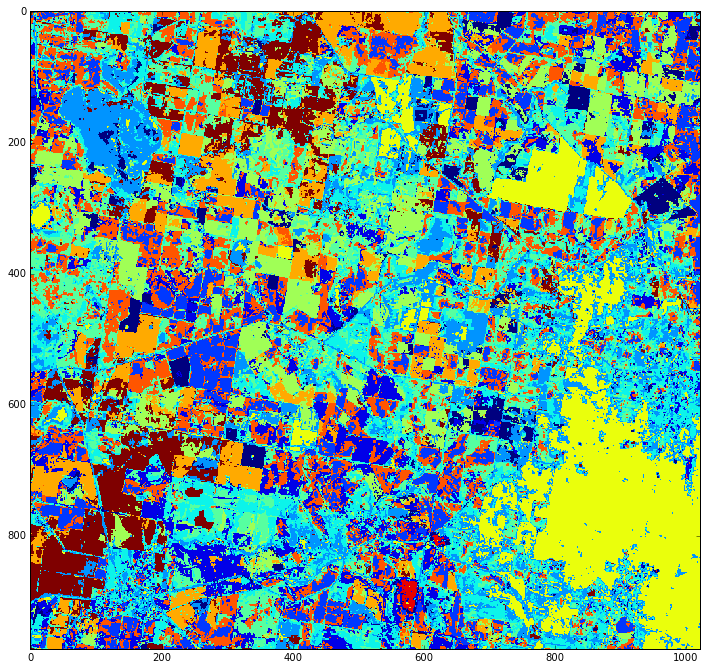

In [98]:
plt.figure(figsize=(12, 12))
plt.imshow(cls_map, interpolation='nearest')
plt.show()

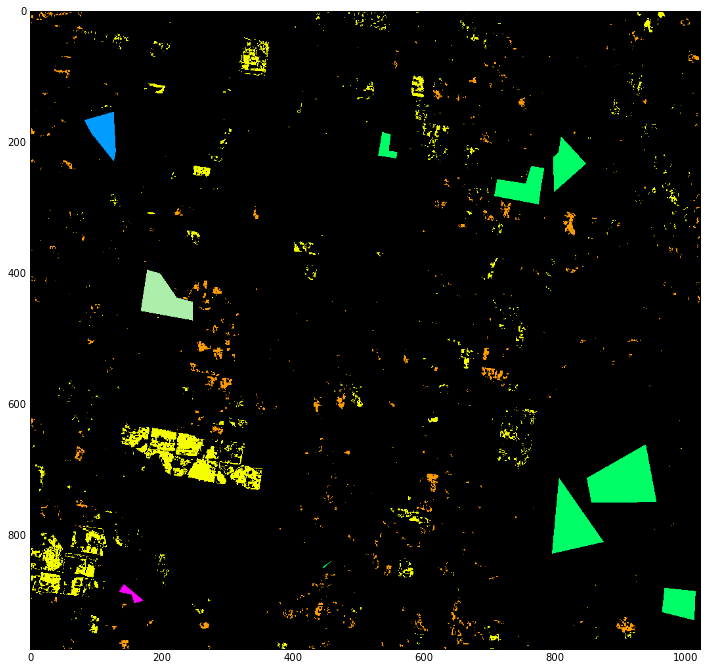

In [99]:
plt.figure(figsize=(12, 12))
plt.imshow(label_image)
plt.show()